

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer/Test')

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="training",
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="validation",
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_test,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
)

Found 118 files belonging to 9 classes.


In [12]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Code to visualize one instance of all the nine classes present in the dataset

In [13]:
import matplotlib.pyplot as plt

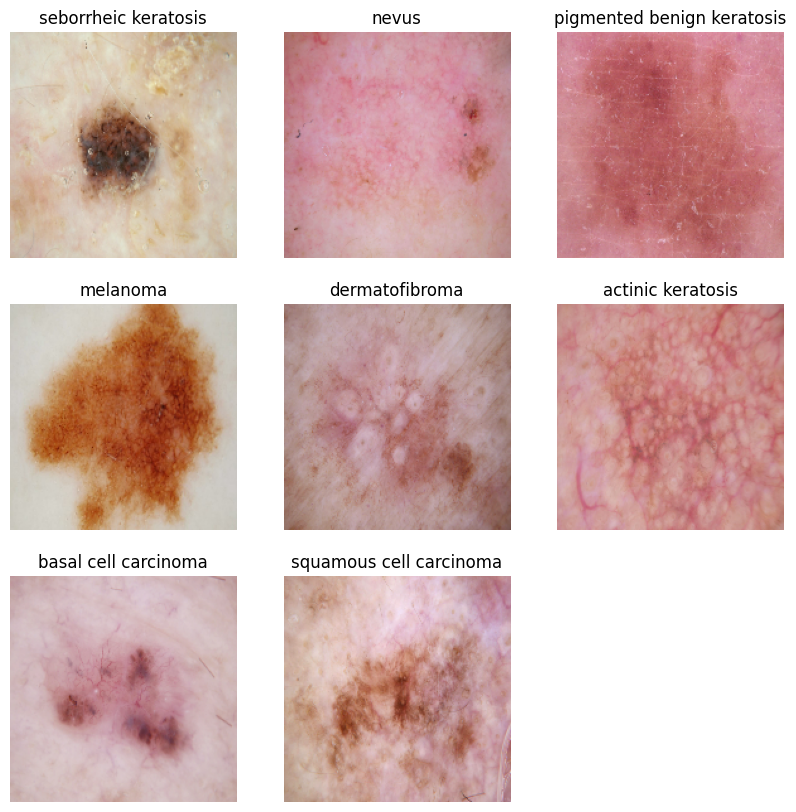

In [14]:
plt.figure(figsize=(10, 10))
covered = []
for images, labels in train_ds.take(3):
  c = 0
  for i in range(tf.shape(images)[0]):
    if labels[i] not in covered:
      ax = plt.subplot(3, 3, c + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")
      covered.append(labels[i])
      c+=1

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a Basic CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [16]:
train_ds.element_spec[0].shape[1:]

TensorShape([180, 180, 3])

In [17]:
### Your code goes here

model = Sequential()

model.add(layers.Rescaling(scale=1./255, offset=0.0))
model.add(layers.Conv2D(32, (3, 3), padding='same',
                 input_shape=train_ds.element_spec[0].shape[1:]))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Activation('relu'))
model.add(layers.Dense(512))
model.add(layers.Activation('relu'))
model.add(layers.Dense(len(class_names)))
model.add(layers.Activation('softmax'))

model.build(train_ds.element_spec[0].shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [18]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [20]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 670s 3s/step - accuracy: 0.3139 - loss: 3.1410 - val_accuracy: 0.1499 - val_loss: 2.7907
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.5679 - loss: 1.2497 - val_accuracy: 0.1499 - val_loss: 3.2389
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.7463 - loss: 0.7323 - val_accuracy: 0.1499 - val_loss: 6.2313
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.8379 - loss: 0.4562 - val_accuracy: 0.1499 - val_loss: 6.1678
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.9146 - loss: 0.2888 - val_accuracy: 0.1655 - val_loss: 4.5780
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9556 - loss: 0.1280 - val_accuracy: 0.2013 - val_loss: 4.0655
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.9594 - loss: 0.1274 - val_accuracy: 0.3020 - val_loss: 3.1112
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.9678 - loss: 0.0862 - val_accuracy: 0.3714 - 

### Visualizing training results

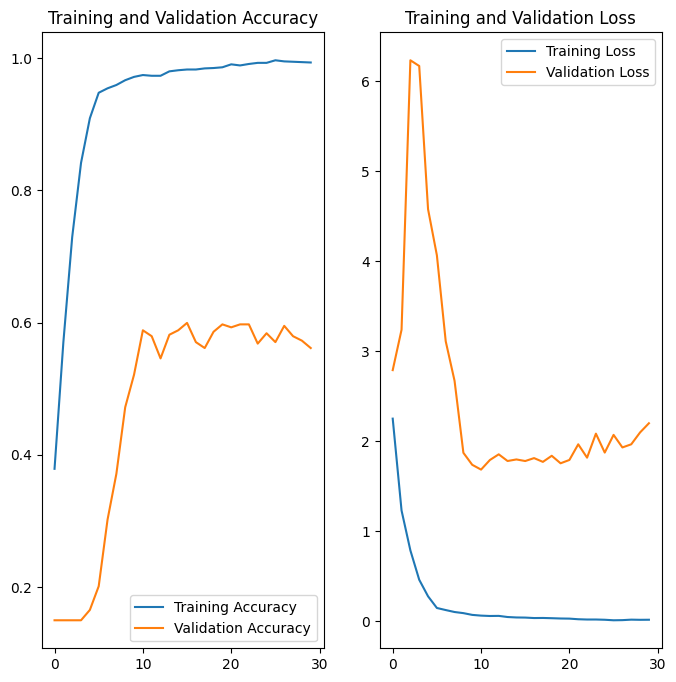

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### Basic CNN:
After the model fit, It seems to be overfitting on the training data. Training accuracy seems to be very high when compared to validation accuracy

### CNN with Dropout layers added:
### Create the model, compile and train the model with dropout layers


In [22]:

model1 = Sequential()

model1.add(layers.Rescaling(scale=1./255, offset=0.0))
model1.add(layers.Conv2D(32, (3, 3), padding='same',
                 input_shape=train_ds.element_spec[0].shape[1:]))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(32, (3, 3)))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Dropout(0.25))

model1.add(layers.Conv2D(64, (3, 3), padding='same'))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(64, (3, 3)))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Dropout(0.25))

model1.add(layers.Flatten())
model1.add(layers.Dense(512))
model1.add(layers.Activation('relu'))
model1.add(layers.Dense(512))
model1.add(layers.Activation('relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(len(class_names)))
model1.add(layers.Activation('softmax'))

model1.build(train_ds.element_spec[0].shape)


### Compiling the model

In [23]:
model1.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [24]:
print(model1.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [25]:
## Your code goes here, note: train your model for 20 epochs
epochs = 30
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.2120 - loss: 8.0043 - val_accuracy: 0.1521 - val_loss: 2.8036
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.3861 - loss: 1.8887 - val_accuracy: 0.1499 - val_loss: 3.5132
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.4711 - loss: 1.5648 - val_accuracy: 0.1499 - val_loss: 4.1529
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.5649 - loss: 1.2794 - val_accuracy: 0.1678 - val_loss: 3.6004
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.6150 - loss: 1.1162 - val_accuracy: 0.2550 - val_loss: 3.2861
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.6287 - loss: 0.9932 - val_accuracy: 0.2796 - val_loss: 2.8537
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.6961 - loss: 0.8679 - val_accuracy: 0.3400 - val_loss: 2.6947
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.7414 - loss: 0.7145 - val_accuracy: 0.4183 -

### Visualizing the results

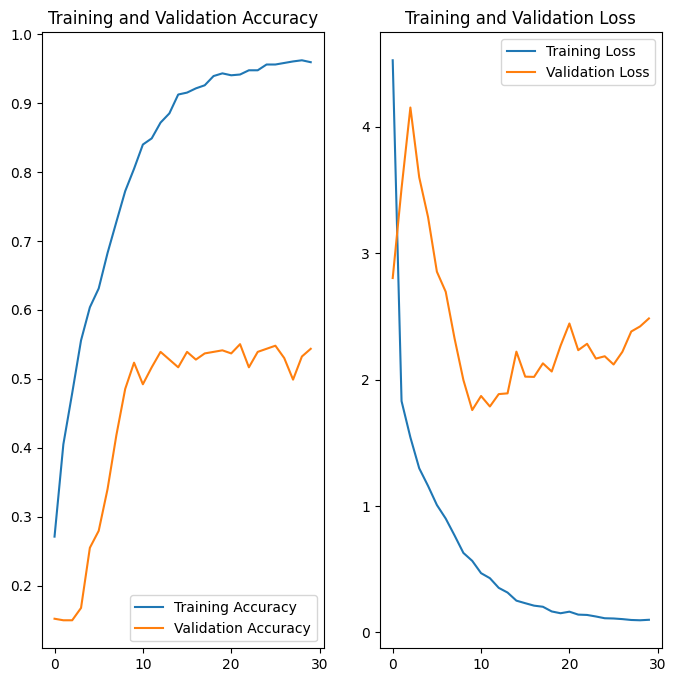

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### [Findings] CNN model with dropout layers

After the model fit, There seems to be very small improvement in the validation accuracy. **bold text**

### Add more layers in the Model:
### Create the model, compile and train the model, add more layers


In [27]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

### Your code goes here

model1 = Sequential()

model1.add(layers.Rescaling(scale=1./255, offset=0.0))
model1.add(layers.Conv2D(32, (3, 3), padding='same',
                 input_shape=train_ds.element_spec[0].shape[1:]))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(32, (3, 3)))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Dropout(0.25))

model1.add(layers.Conv2D(64, (3, 3), padding='same'))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(64, (3, 3)))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Dropout(0.25))

model1.add(layers.Conv2D(128, (3, 3), padding='same'))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(128, (3, 3)))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Dropout(0.25))

model1.add(layers.Flatten())
model1.add(layers.Dense(512))
model1.add(layers.Activation('relu'))
model1.add(layers.Dense(512))
model1.add(layers.Activation('relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(len(class_names)))
model1.add(layers.Activation('softmax'))

model1.build(train_ds.element_spec[0].shape)


### Compiling the model

In [28]:
model1.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [29]:
## Your code goes here, note: train your model for 20 epochs
epochs = 30
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.2895 - loss: 3.8148 - val_accuracy: 0.1499 - val_loss: 2.4766
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.4229 - loss: 1.7103 - val_accuracy: 0.1499 - val_loss: 4.4507
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.4988 - loss: 1.4463 - val_accuracy: 0.1499 - val_loss: 4.8928
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.5253 - loss: 1.3693 - val_accuracy: 0.2103 - val_loss: 3.5630
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.5728 - loss: 1.2417 - val_accuracy: 0.1499 - val_loss: 5.5484
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.6157 - loss: 1.1259 - val_accuracy: 0.2573 - val_loss: 3.1998
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.6663 - loss: 1.0013 - val_accuracy: 0.2483 - val_loss: 3.3627
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.6891 - loss: 0.8443 - val_accuracy: 0.

### Visualizing the results

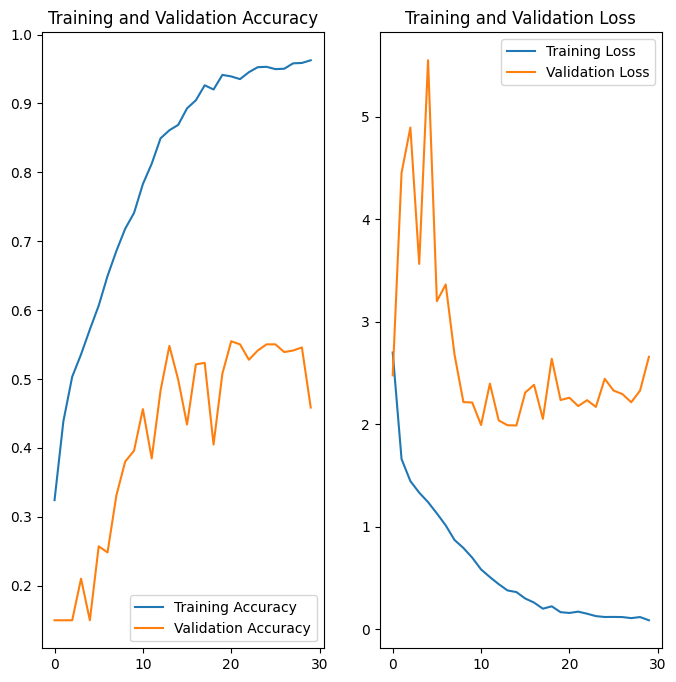

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### [Findings] CNN model with more layers

After the model fit, Adding more layers doesn't seem to add much value, the validation accuracy still seems to be in the same range.



### CNN Model, Increasing the number of filters:
### Create the model, compile and train the model, increase num of filters


In [31]:

model1 = Sequential()

model1.add(layers.Rescaling(scale=1./255, offset=0.0))
model1.add(layers.Conv2D(64, (3, 3), padding='same',
                 input_shape=train_ds.element_spec[0].shape[1:]))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(64, (3, 3)))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Dropout(0.25))

model1.add(layers.Conv2D(128, (3, 3), padding='same'))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(128, (3, 3)))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Dropout(0.25))

model1.add(layers.Flatten())
model1.add(layers.Dense(512))
model1.add(layers.Activation('relu'))
model1.add(layers.Dense(512))
model1.add(layers.Activation('relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(len(class_names)))
model1.add(layers.Activation('softmax'))

model1.build(train_ds.element_spec[0].shape)


### Compiling the model

In [32]:
model1.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
print(model1.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_23 (Activation)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_24 (Activation)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_25 (Activation)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_26 (Activation)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


### Training the model

In [34]:
## Your code goes here, note: train your model for 20 epochs
epochs = 30
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 373ms/step - accuracy: 0.2136 - loss: 13.0087 - val_accuracy: 0.1499 - val_loss: 5.4413
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - accuracy: 0.4161 - loss: 1.8370 - val_accuracy: 0.1499 - val_loss: 5.7583
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - accuracy: 0.5182 - loss: 1.4014 - val_accuracy: 0.1521 - val_loss: 4.8834
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.5517 - loss: 1.2287 - val_accuracy: 0.1902 - val_loss: 3.8938
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.6481 - loss: 1.0275 - val_accuracy: 0.2081 - val_loss: 4.4729
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 0.6802 - loss: 0.9308 - val_accuracy: 0.2237 - val_loss: 3.9006
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - accuracy: 0.7072 - loss: 0.8090 - val_accuracy: 0.2774 - val_loss: 3.3817
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - accuracy: 0.7553 - loss: 0.6664 - val_acc

### Visualizing the results

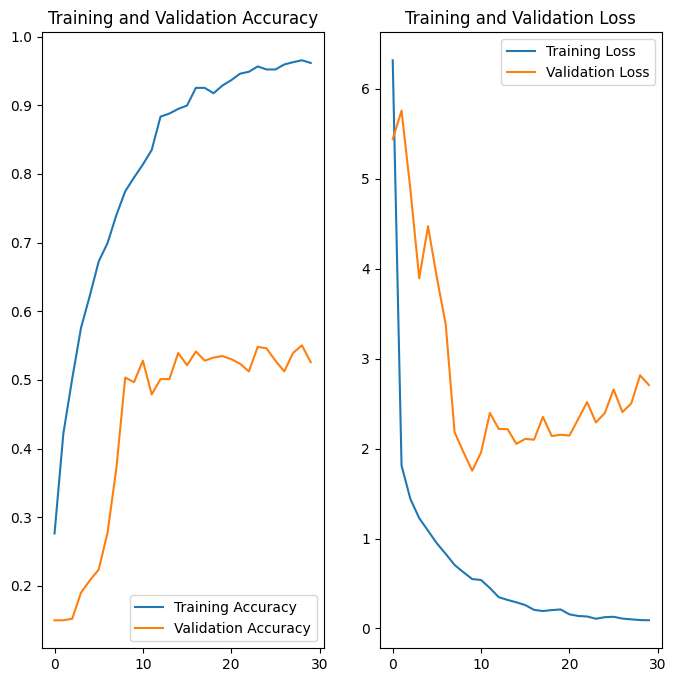

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### [Findings] CNN model with increased filters

Aftet the model fit, Increasing the number of filters didn't result in any significant improvement in the validation data accuracy.

#### Find the distribution of classes in the training dataset.
**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

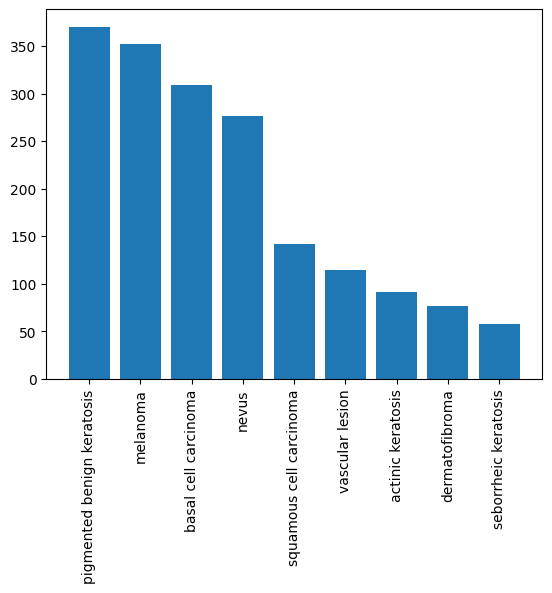

In [36]:
vals = pd.DataFrame(np.concatenate([labels.numpy() for labels in train_ds.map(lambda x, y: y)]))

plt.bar(x=[class_names[i[0]] for i in list(vals.value_counts().index)], height=vals.value_counts())
plt.xticks(rotation=90)
plt.show()

#### [findings] Class distributions:

There are classes with just 77 images and the maximum upto 400 in some classes. There is a high class imbalance.
* `seborrheic keratosis` seems to be the class with least data
* `pigmented benign keratosis` is the class with largest data.


#### Rectify the class imbalance
#### **Context:** Use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [37]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [38]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78B6E009FE20>: 100%|██████████| 500/500 [00:22<00:00, 21.93 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78B6E02F2170>: 100%|██████████| 500/500 [00:24<00:00, 20.79 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78B6E01C6500>: 100%|██████████| 500/500 [00:18<00:00, 26.55 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x78B75860EB60>: 100%|██████████| 500/500 [01:25<00:00,  5.82 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=962x723 at 0x78B6E07AC190>: 100%|██████████| 500/500 [01:25<00:00,  5.87 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78B76991BF40>: 100%|██████████| 500/500 [00:21<00:00, 22.84 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78B7584BB490>: 100%|██████████| 500/500 [00:39<00:00, 12.57 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78B76991BF70>: 100%|██████████| 500/500 [00:19<00:00, 25.36 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78B758543CA0>: 100%|██████████| 500/500 [00:18<00:00, 26.50 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [39]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [40]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [41]:
# import shutil
# for dir in glob(os.path.join(data_dir_train, '*','output')):
#   shutil.rmtree(dir)

In [42]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [43]:
dataframe_dict = dict(zip(path_list, lesion_list))
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [44]:
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

original_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


In [46]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)
new_df = pd.concat([original_df, df2], ignore_index=True)

In [48]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.



#### Train the model on the data created using Augmentor

In [49]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [50]:
# data_dir_train="path to directory with training data + data created using augmentor"


train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="training",
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [51]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="validation",
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


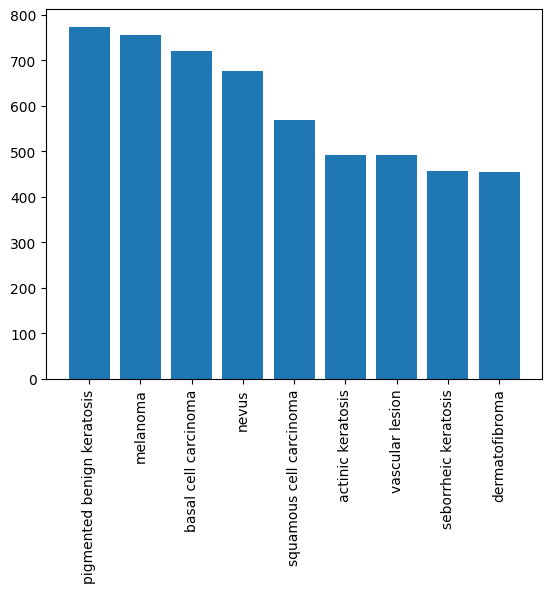

In [52]:
## Your code goes here.
vals = pd.DataFrame(np.concatenate([labels.numpy() for labels in train_ds.map(lambda x, y: y)]))
# vals.value_counts().plot.bar(x=[class_names[i[0]] for i in list(vals.value_counts().index)])

plt.bar(x=[class_names[i[0]] for i in list(vals.value_counts().index)], height=vals.value_counts())
plt.xticks(rotation=90)
plt.show()


#### Create your model

In [53]:

model1 = Sequential()

model1.add(layers.Rescaling(scale=1./255, offset=0.0))
model1.add(layers.Conv2D(32, (3, 3), padding='same',
                 input_shape=train_ds.element_spec[0].shape[1:]))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(32, (3, 3)))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Dropout(0.25))

model1.add(layers.Conv2D(64, (3, 3), padding='same'))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(64, (3, 3)))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Dropout(0.25))

model1.add(layers.Flatten())
model1.add(layers.Dense(256))
model1.add(layers.Activation('relu'))
model1.add(layers.Dense(256))
model1.add(layers.Activation('relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(len(class_names)))
model1.add(layers.Activation('softmax'))

model1.build(train_ds.element_spec[0].shape)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Compile your model

In [54]:
model1.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [55]:
print(model1.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_30 (Activation)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_31 (Activation)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_32 (Activation)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_33 (Activation)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


#### **Todo:**  Train your model

In [56]:
## Your code goes here, note: train your model for 20 epochs
epochs = 40
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 62s 315ms/step - accuracy: 0.2521 - loss: 3.9254 - val_accuracy: 0.1039 - val_loss: 4.2630
Epoch 2/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 67s 258ms/step - accuracy: 0.4402 - loss: 1.5313 - val_accuracy: 0.1440 - val_loss: 3.0756
Epoch 3/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 256ms/step - accuracy: 0.5473 - loss: 1.2085 - val_accuracy: 0.4491 - val_loss: 1.8352
Epoch 4/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 84s 269ms/step - accuracy: 0.6282 - loss: 0.9984 - val_accuracy: 0.4343 - val_loss: 1.9425
Epoch 5/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 251ms/step - accuracy: 0.7082 - loss: 0.8137 - val_accuracy: 0.4566 - val_loss: 1.9504
Epoch 6/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 84s 264ms/step - accuracy: 0.7421 - loss: 0.6770 - val_accuracy: 0.1396 - val_loss: 12.6366
Epoch 7/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 257ms/step - accuracy: 0.7773 - loss: 0.5974 - val_accuracy: 0.5531 - val_loss: 1.4751
Epoch 8/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 255ms/step - accuracy: 0.8231 - loss: 

#### Visualize the model results

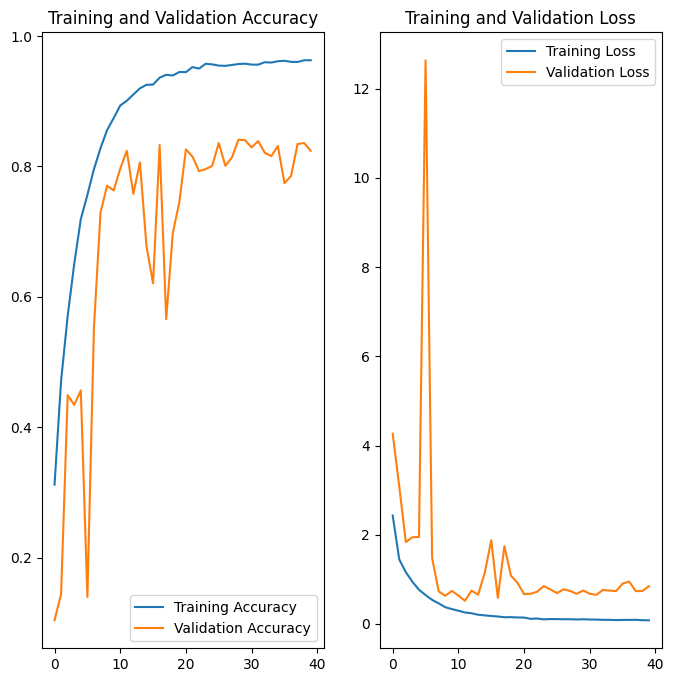

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### [Findings] Final CNN model

Features included:
- Batch normalisation,
- dropout layers,
- SGD optimiser
- Image agumentation to deal with class imbalance
- Rescaling the input to 0-1


The Final model went upto ~85% in validation accuracy. Class imbalnce removal seems to have helped significantly in the increase in accuracy.

In [58]:
model1.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 45s 12s/step - accuracy: 0.3992 - loss: 5.1775


[4.941620349884033, 0.4067796468734741]